In [23]:
from typing import Callable, Optional, Tuple, Any, List, Dict
import os
from contextlib import contextmanager

import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import DatasetFolder, ImageFolder, VisionDataset
from torchvision import models
from torch.utils.data import Subset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image

In [8]:
def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

class SportDataset(VisionDataset):
    NUM_CLASSES = 100
    META_FNAME = "release_data.csv"

    def __init__(
        self, root: str, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None,
        train: bool = True
    ):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.meta = None
        self.root = root
        self.class_to_idx = self.find_classes(root)
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        self.loader = pil_loader

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        fname, target = self.meta.iloc[index][['filename', 'class id']]
        path = os.path.join(self.root, 'data', 'data', fname)
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.meta)

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        meta_path = os.path.join(directory, SportDataset.META_FNAME)
        self.meta = pd.read_csv(meta_path)
        if self.train:
            self.meta = self.meta[self.meta['class id'] != -1]
            class_to_idx = dict(self.meta[['label', 'class id']].to_numpy())
            assert len(class_to_idx) == SportDataset.NUM_CLASSES
        else:
            self.meta = self.meta[self.meta['class id'] == -1]
            class_to_idx = {np.nan: -1}
        return class_to_idx


Load train and test datasets:

In [9]:
dataset = SportDataset('./hw-ucu-12023-4-100-sports-image-classification', transform=T.ToTensor(), train=True)
test_dataset = SportDataset('./hw-ucu-12023-4-100-sports-image-classification', transform=T.ToTensor(), train=False)

In [11]:
def display_random_samples(dataset: Subset, n = 16, fig = None, idx_to_class = None):
    """Given a SportDataset, display n random samples from it in a grid.
    """
    
    if idx_to_class is SportDataset and idx_to_class is None:
        idx_to_class = dataset.idx_to_class
    
    num_display = min(n, len(dataset))
    sample_idxes = np.random.choice(len(dataset), (num_display,), replace=False)
    
    if fig == None:
        fig = plt.figure()
    fig_width = int(np.ceil(np.sqrt(num_display)))
    fig_height = (num_display + fig_width - 1) // fig_width
    
    for i in range(num_display):
        ax = fig.add_subplot(fig_height, fig_width, i + 1)
        idx = sample_idxes[i]
        img, idx = dataset[idx]
        if idx_to_class:
            label = idx_to_class[idx]
            ax.set_title(label)
        img = img.cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)


Split dataset into train and val:

In [12]:
@contextmanager
def temp_seed(seed: int):
    """Set seed for both numpy and torch.
    Combine numpy and torch fork_rng.
    """
    np_state = np.random.get_state()
    np.random.seed(seed)
    try:
        with torch.random.fork_rng():
            yield
    finally:
        np.random.set_state(np_state)


Display samples from train, val and test parts:

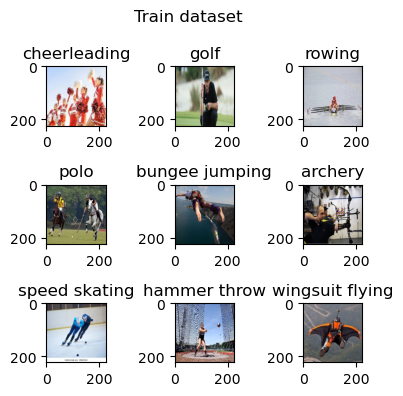

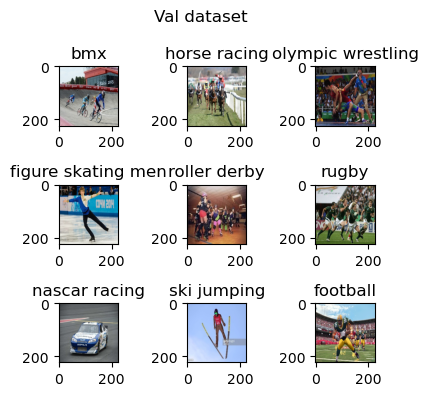

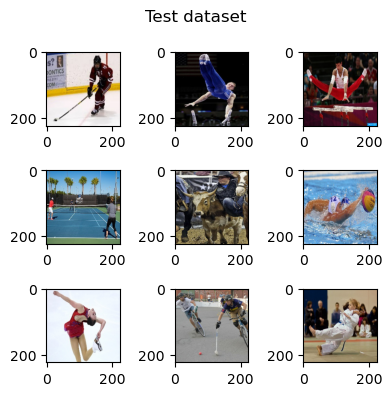

In [14]:
with temp_seed(42):
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

    fig = plt.figure(figsize=(4, 4))
    fig.suptitle('Train dataset')
    display_random_samples(train_dataset, 9, fig=fig, idx_to_class=dataset.idx_to_class)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(4, 4))
    fig.suptitle('Val dataset')
    display_random_samples(val_dataset, 9, fig=fig, idx_to_class=dataset.idx_to_class)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(4, 4))
    fig.suptitle('Test dataset')
    display_random_samples(test_dataset, 9, fig=fig)
    plt.tight_layout()
    plt.show()


In [42]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

In [43]:
in_features = model.classifier[6].weight.shape[1]
model.classifier[6] = nn.Linear(in_features, SportDataset.NUM_CLASSES)

In [44]:
model.cuda();

In [45]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, pin_memory=True)
optimizer = torch.optim.Adam(model.parameters())

losses = []
for it, (imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.cuda(), labels.cuda()
    loss = F.cross_entropy(model(imgs), labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if it % 10 == 9:
        print(np.mean(losses), flush=True)
        losses = []


4.744184732437134
4.6588750839233395
4.654659080505371
4.603353834152221
4.61301622390747
4.609623146057129
4.6031828880310055
4.604886293411255
4.600472927093506
4.611986398696899
4.605291271209717
4.604675674438477
4.604670429229737
4.601453733444214
4.611687135696411
4.59865369796753
4.602662563323975
4.594830560684204
4.601985311508178
4.589431238174439
4.599658536911011
4.6070350170135494
4.58766131401062
4.603693342208862
4.6017231941223145
4.607749128341675
4.595512247085571
4.598474550247192
4.606364727020264
4.5972143650054935
4.610807800292969
4.59796175956726
4.596874475479126
4.608780765533448
4.603631830215454
4.599879217147827
4.5994391441345215
4.592763090133667


In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 